# Training the Model

The meat of our project is here. Here we load the data, train the model, run a prediction, and sample frm the results

## The Preliminary Section

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

import numpy as np
import os
import random
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Define paths
base_path = '/content/drive/My Drive/ML_projects/VesselProject/RetinalImages/Processed_cropped'
train_images_path = f'{base_path}/Train/Images'
train_masks_path = f'{base_path}/Train/Masks'
test_images_path = f'{base_path}/Test/Images'
test_masks_path = f'{base_path}/Test/Masks'

# Define the path to the ML_projects folder
project_path = '/content/drive/My Drive/ML_projects/VesselProject'

# Change the current working directory to ML_projects
os.chdir(project_path)

The following section is for all our functions:

In [4]:
# Loading Functions

def load_image_and_mask(image_file, mask_file):
    # Load given image
    image = img_to_array(load_img(image_file, color_mode="grayscale")) / 255.
    mask = img_to_array(load_img(mask_file, color_mode="grayscale")) / 255.
    return image, mask

def load_images_and_masks(images_path, masks_path):
    # Load the repository
    image_files = [os.path.join(images_path, f) for f in os.listdir(images_path)]
    mask_files = [os.path.join(masks_path, f) for f in os.listdir(masks_path)]

    # Ensure the files are in the same order if necessary
    image_files.sort()
    mask_files.sort()

    # Preallocate memory for the images and masks
    num_images = len(image_files)
    example_image = img_to_array(load_img(image_files[0], color_mode="grayscale"))
    image_shape = example_image.shape
    images = np.empty((num_images, *image_shape), dtype=np.float32)
    masks = np.empty((num_images, *image_shape), dtype=np.float32)

    # Load images and masks using ThreadPoolExecutor
    with ThreadPoolExecutor() as executor:
        results = executor.map(load_image_and_mask, image_files, mask_files)

    for i, (image, mask) in enumerate(results):
        images[i] = image
        masks[i] = mask

    return images, masks

# Function for plotting examples

def plot_examples(images, true_masks, predicted_masks, num_examples=3):
    # Ensure that num_examples is not greater than the length of the dataset
    num_examples = min(num_examples, len(images))

    # Randomly select indices
    random_indices = random.sample(range(len(images)), num_examples)

    plt.figure(figsize=(10, num_examples * 3))

    for i, idx in enumerate(random_indices):
        plt.subplot(num_examples, 3, i*3 + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_examples, 3, i*3 + 2)
        plt.imshow(true_masks[idx].squeeze(), cmap='gray')
        plt.title("True Mask")
        plt.axis('off')

        plt.subplot(num_examples, 3, i*3 + 3)
        plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

# Functions for evaluation. To be used after training

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * (p * r) / (p + r + tf.keras.backend.epsilon())
    return f1

## The Training Section

Now we need to load our Model. Our model is a U-net, known for it's success in biomedical segmentation, making it perfect for our application

In [5]:
# Load the model from Model.py

from Model import unet
model = unet(input_size=(128,128,1))


optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy',precision, recall, f1_score]) # create another variable
                                                                                  # for optimizer for tuning
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['batch_normalization[0][0

In [6]:
# Load the test images
test_images, test_masks = load_images_and_masks(test_images_path, test_masks_path)

In [7]:
# Load the train images (Note: takes time)
train_images, train_masks = load_images_and_masks(train_images_path, train_masks_path)

In [8]:
# Split
train_images, val_images, train_masks, val_masks = train_test_split(train_images,
                                                                    train_masks, test_size=0.1,
                                                                    random_state=42
                                                                    )

In [9]:
# Create a checkpoint for best model

checkpoint_path = 'unet_best_model.h5'
# Delete the previous model for a fresh run
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print(f'Removed previous checkpoint file: {checkpoint_path}')

model_checkpoint = ModelCheckpoint('unet_best_model.h5', monitor='val_loss', save_best_only=True)

In [10]:
# Train the Model (THE SAUCE)
print('Training the model... the sauce')
history = model.fit(
    x=train_images,
    y=train_masks,
    batch_size=16,
    epochs=50,
    validation_data=(val_images, val_masks),
    callbacks=[model_checkpoint]
)

print('Training completed!!')

Training the model... the sauce
Epoch 1/50
1388/1388 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.7834 - precision: 0.6128 - recall: 0.6285 - f1_score: 0.6039

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1388/1388 [==============================] - 363s 245ms/step - loss: 0.3152 - accuracy: 0.7834 - precision: 0.6128 - recall: 0.6285 - f1_score: 0.6039 - val_loss: 0.1673 - val_accuracy: 0.8066 - val_precision: 0.6945 - val_recall: 0.6462 - val_f1_score: 0.6690
Epoch 2/50
1388/1388 [==============================] - 328s 236ms/step - loss: 0.1488 - accuracy: 0.8081 - precision: 0.7156 - recall: 0.6214 - f1_score: 0.6639 - val_loss: 0.1516 - val_accuracy: 0.8047 - val_precision: 0.6391 - val_recall: 0.6997 - val_f1_score: 0.6675
Epoch 3/50
1388/1388 [==============================] - 328s 236ms/step - loss: 0.1245 - accuracy: 0.8093 - precision: 0.7311 - recall: 0.6327 - f1_score: 0.6771 - val_loss: 0.1134 - val_accuracy: 0.8094 - val_precision: 0.7517 - val_recall: 0.6326 - val_f1_score: 0.6866
Epoch 4/50
1388/1388 [==============================] - 328s 236ms/step - loss: 0.1151 - accuracy: 0.8102 - precision: 0.7404 - recall: 0.6438 - f1_score: 0.6876 - val_loss: 0.1102 - val_accuracy

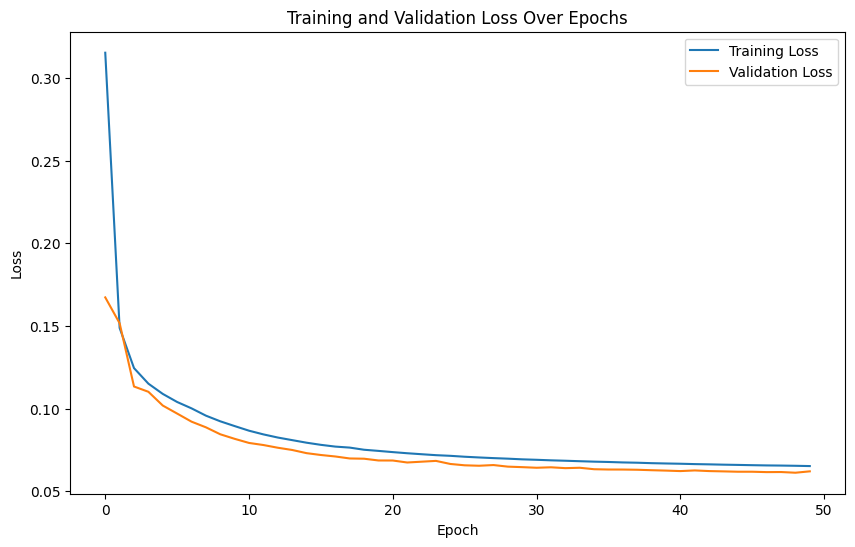

In [11]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## The Results and Prediction Section:

In [ ]:
# Test the results
test_loss, test_acc, test_prec, test_recall, test_f1 = model.evaluate(test_images, test_masks, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_prec}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")

106/106 [==============================] - 20s 136ms/step - loss: 0.1567 - accuracy: 0.8078 - precision: 0.7476 - recall: 0.6599 - f1_score: 0.6993
Test Loss: 0.15670348703861237
Test Accuracy: 0.8077972531318665
Test Precision: 0.7475707530975342
Test Recall: 0.6598526835441589
Test F1 Score: 0.6993467211723328


In [ ]:
# Predict results
predicted_masks = model.predict(test_images, verbose=1)

106/106 [==============================] - 10s 96ms/step


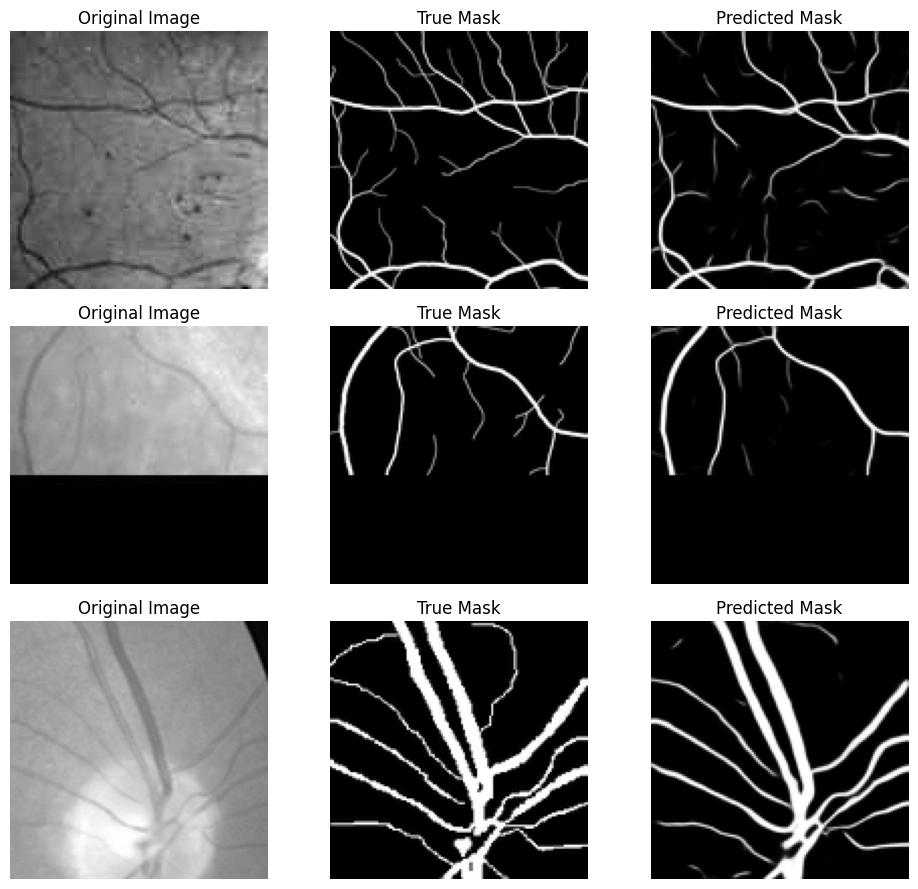

<Figure size 640x480 with 0 Axes>

In [ ]:
# Assuming your test_images, test_masks, and predicted_masks are numpy arrays
plot_examples(test_images, test_masks, predicted_masks, num_examples=3)

In [ ]:
# Define the directory to save predicted masks
predicted_masks_dir = os.path.join(project_path, 'RetinalImages', 'Predicted_masks')
listed_mask_names = sorted(os.listdir(test_masks_path))

# Create the directory if it doesn't exist
os.makedirs(predicted_masks_dir, exist_ok=True)

for i, mask in enumerate(predicted_masks):
    mask_filename = os.path.splitext(os.path.basename(listed_mask_names[i]))[0] + '.jpg'
    predicted_mask_path = os.path.join(predicted_masks_dir, mask_filename)

    # Check if the array has a single color channel and reshape if needed
    if len(mask.shape) == 3 and mask.shape[2] == 1:
        mask = mask.squeeze(axis=2)

    # Convert the mask to an image format and save as .jpg
    mask_image = Image.fromarray((mask * 255).astype(np.uint8))
    mask_image.save(predicted_mask_path, format='JPEG')

print('Saving all predicted masks completed.')